# **Experiment Notebook**



In this experiment, a RandomForestClassifier is used to predict which players will be drafted in the NBA. The model aims to improve prediction accuracy by leveraging insights from the data, making it more effective in identifying potential draftees.


### 0. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings('ignore')

### 1.   Load Dataset

In [3]:
# set path to dataset
train_file_url = '../data/raw/train.csv'
test_file_url = '../data/raw/test.csv'

In [4]:
# read csv files
df = pd.read_csv(train_file_url)
test_df = pd.read_csv(test_file_url)

### 2. Prepare Data

In [6]:
df_cleaned = df.copy()
df_clean_test = test_df.copy()

In [7]:
#dropping irrelevant features
df_cleaned = df_cleaned.drop(columns=['player_id', 'team', 'num', 'Rec_Rank', 'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio', 'pick'])
df_clean_test = df_clean_test.drop(columns=['team', 'num', 'Rec_Rank', 'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio', 'pick'])

In [8]:
# checking null values
print(df_cleaned.isnull().sum().sum(), df_clean_test.isnull().sum().sum())

4531 562


In [9]:
# data fillup with mode or categorical and mean for numerical
for column in df_clean_test.columns:
    if df_clean_test[column].dtype == 'object' or df_clean_test[column].dtype.name == 'category':
        # Fill categorical columns with mode
        df_clean_test[column].fillna(df_clean_test[column].mode()[0], inplace=True)
    else:
        # Fill numerical columns with mean
        df_clean_test[column].fillna(df_clean_test[column].mean(), inplace=True)

In [10]:
# check data contains null values
print(df_cleaned.isnull().sum().sum(), df_clean_test.isnull().sum().sum())

4531 0


In [11]:
# dropping null values
df_cleaned.dropna(inplace=True)

In [12]:
#  shape of the dataset
df_cleaned.shape

(43028, 50)

### 3. Split Dataset

In [13]:
# declare the target variable
target = 'drafted'

In [14]:
# declare features and target
y = df_cleaned.pop(target)
X = df_cleaned

# declare test set
X_test = df_clean_test

In [15]:
#  differentiate num and cat cols
num_cols = list(X.select_dtypes('number').columns)
cat_cols = list(set(X.columns) - set(num_cols))

In [16]:
from sklearn.model_selection import train_test_split

# split the data into val and train set
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# create a preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('ord', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

### 4. Train Machine Learning Model

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# create a pipeline
model = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(max_depth=10))
])

In [20]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ord', StandardScaler(),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'porpag',
                                                   'adjoe', 'pfr', 'year',
                                                   'ast_tov', 'drtg', 'adrtg',
                                                   'dporpag', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['conf', 'type', 'yr',
                                                   'ht'])])),
                ('model', RandomForestClassifier(max_depth=10))])

In [21]:
# predicting the model on train and val set 
y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_val)

In [22]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# classification report
train_perf = classification_report(y_train, y_train_preds)
print(train_perf)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     46174
         1.0       1.00      0.62      0.76       444

    accuracy                           1.00     46618
   macro avg       1.00      0.81      0.88     46618
weighted avg       1.00      1.00      1.00     46618



The model is suffering from class imbalance where it performs extremely well on the majority class (undrafted) but struggles with recall for the minority class (drafted). 

In [24]:
y_pred_prob = model.predict_proba(X_train)[:, 1]

# print ROC AUC score
roc_auc = roc_auc_score(y_train, y_pred_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9998


In [25]:
y_pred_val_prob = model.predict_proba(X_val)[:, 1]

# print ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred_val_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9999


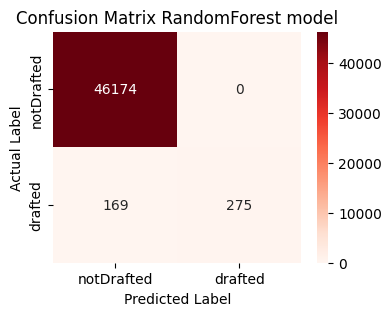

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

#  confusion matrix for train model
cm = confusion_matrix(y_train, y_train_preds)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix RandomForest model')
plt.show()

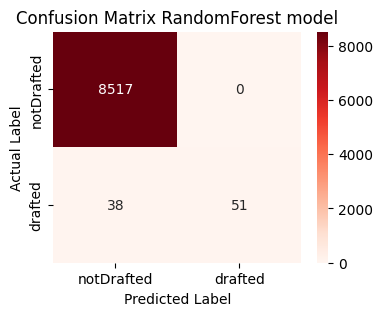

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# display confusion matrix for the validation model
cm = confusion_matrix(y_val, y_val_preds)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix RandomForest model')
plt.show()

The model performs almost perfectly on the notDrafted class, with no false positives. However, it struggles to correctly identify all drafted players, as indicated by 169 false negatives. This results in a perfect precision for the drafted class but lower recall.

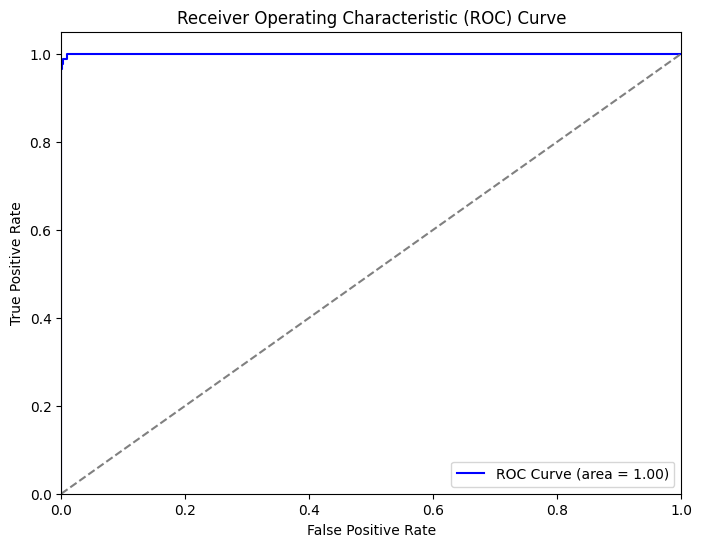

In [28]:
# Compute ROC curve data (fpr = false positive rate, tpr = true positive rate)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
# randomforest model max depth 5
model_1 = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(max_depth=5))
])

In [30]:
# train the model
model_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ord', StandardScaler(),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'porpag',
                                                   'adjoe', 'pfr', 'year',
                                                   'ast_tov', 'drtg', 'adrtg',
                                                   'dporpag', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['conf', 'type', 'yr',
                                                   'ht'])])),
                ('model', RandomForestClassifier(max_depth=5))])

In [31]:
# predict the train and val 
y_train_preds_1 = model_1.predict(X_train)
y_val_preds_1 = model_1.predict(X_val)

In [32]:
# display the classification model
train_perf = classification_report(y_train, y_train_preds_1)
print(train_perf)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     46174
         1.0       0.93      0.19      0.32       444

    accuracy                           0.99     46618
   macro avg       0.96      0.60      0.66     46618
weighted avg       0.99      0.99      0.99     46618



recall is reduced to 0.19 here so this model is not performing well

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

# predict the probabilites
y_pred_prob_1 = model_1.predict_proba(X_train)[:, 1]

# print ROC AUC score
roc_auc_1 = roc_auc_score(y_train, y_pred_prob)
print(f'ROC AUC Score: {roc_auc_1:.4f}')

ROC AUC Score: 0.9998


In [34]:
# predict the probabilites
y_pred_val_prob_1 = model_1.predict_proba(X_val)[:, 1]

# print ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred_val_prob_1)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9867


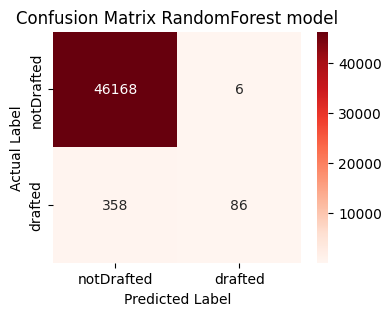

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# display the confusion matrix
cm = confusion_matrix(y_train, y_train_preds_1)

# display confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix RandomForest model')
plt.show()

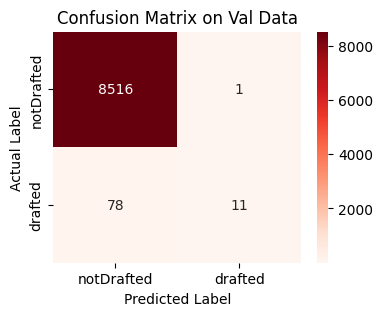

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# display the confusion matrix
cm = confusion_matrix(y_val, y_val_preds_1)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Val Data')
plt.show()

The model is not performing better for max depth 5

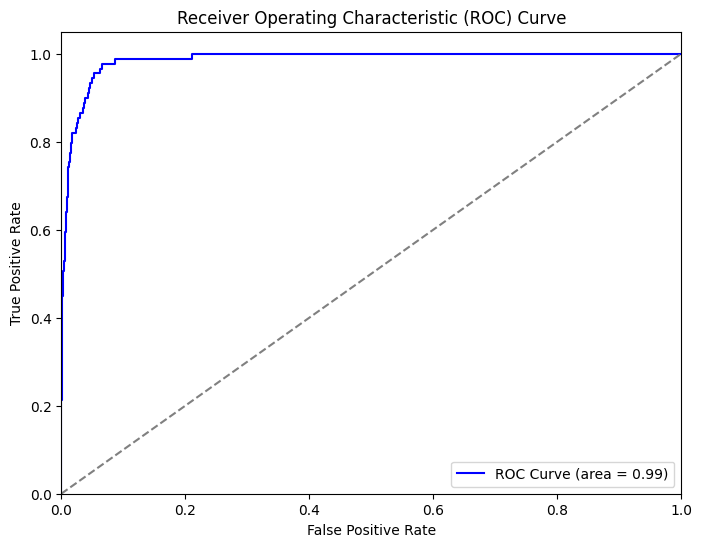

In [37]:
# compute ROC curve data 
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_prob_1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
# RandomForest with maxdepth 8
model_2 = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(max_depth=8))
])

In [39]:
# train the model
model_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ord', StandardScaler(),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'porpag',
                                                   'adjoe', 'pfr', 'year',
                                                   'ast_tov', 'drtg', 'adrtg',
                                                   'dporpag', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['conf', 'type', 'yr',
                                                   'ht'])])),
                ('model', RandomForestClassifier(max_depth=8))])

In [40]:
y_train_preds_2 = model_2.predict(X_train)
y_val_preds_2 = model_2.predict(X_val)

In [41]:
train_perf = classification_report(y_train, y_train_preds_2)
print(train_perf)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     46174
         1.0       1.00      0.42      0.59       444

    accuracy                           0.99     46618
   macro avg       1.00      0.71      0.80     46618
weighted avg       0.99      0.99      0.99     46618



The recall is slighly better than before but needs a lot of improvement.

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob_2 = model_2.predict_proba(X_train)[:, 1]

# Step 5: Print ROC AUC score
roc_auc_1 = roc_auc_score(y_train, y_pred_prob)
print(f'ROC AUC Score: {roc_auc_1:.4f}')

ROC AUC Score: 0.9998


In [43]:
y_pred_val_prob_2 = model_2.predict_proba(X_val)[:, 1]

# Step 5: Print ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred_val_prob_1)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9867


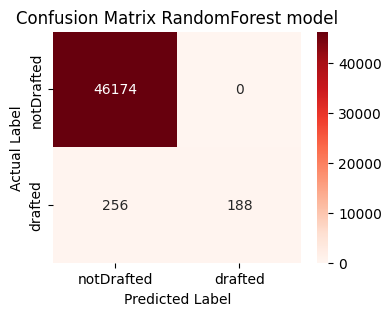

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

# display the confusion matrix
cm = confusion_matrix(y_train, y_train_preds_2)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix RandomForest model')
plt.show()

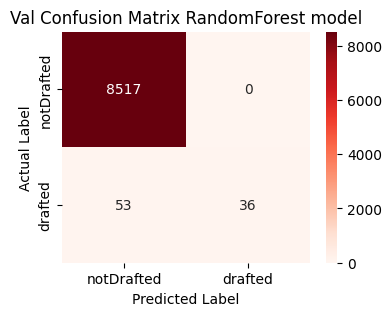

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

# display the confusion matrix
cm = confusion_matrix(y_val, y_val_preds_2)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["notDrafted", "drafted"], yticklabels=["notDrafted", "drafted"])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Val Confusion Matrix RandomForest model')
plt.show()

Slightly better but not the best model

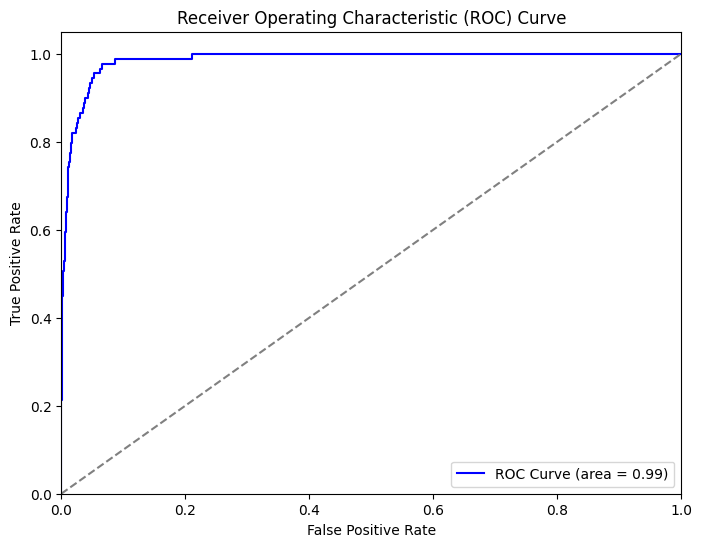

In [46]:
# ROC curve data
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_prob_1)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
# save submissions for kaggle for test data
test_df['predicted_probability'] = model.predict_proba(X_test)[:,1]
test_df[['player_id', 'predicted_probability']].to_csv('submission.csv', index=False)

In [48]:
test_df[['player_id', 'predicted_probability']].head()

,player_id,predicted_probability
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.000007
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.000006
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.000673
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.000015
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.001705


The first model is clearly overfitting, as indicated by its perfect validation ROC score of **1.00**, but this typically signals poor generalization to unseen data. Although the second and third models have excellent validation ROC scores of **0.99**, they fail to achieve the same level of performance on the test set, with a test score of **0.92**. This suggests that while the models perform well during validation, they may still be overfitting or not capturing the true patterns in the data, leading to reduced generalization on the test set.